In [1]:
from torchtext.legacy import data
from torchtext.vocab import GloVe
from tqdm import tqdm
import torch.nn as nn
import torch.nn.utils
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print(f'GPU available: {torch.cuda.is_available()}')

Wed Dec  8 00:38:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
#%% read the data (this is the way to read the input column as list of strings)
tokenize = lambda x: x.split()
TEXT = data.Field(sequential = True, tokenize = tokenize, lower = True, 
                  include_lengths = True, batch_first = True, fix_length = 300)
LABEL = data.LabelField(sequential = False, use_vocab = False)

train = data.TabularDataset(path="complaints_train_notoken.csv",format="csv",
                                 fields=[
                                         ('input', TEXT),
                                         ('label', LABEL)], skip_header=True)

test = data.TabularDataset(path="complaints_test_notoken.csv",format="csv",
                                 fields=[
                                         ('input', TEXT),
                                         ('label', LABEL)], skip_header=True)

In [9]:
TEXT.build_vocab(train, test, vectors = GloVe(name='6B', dim = 300))

word_embeddings = TEXT.vocab.vectors

In [10]:
print(TEXT.vocab.vectors.shape)

torch.Size([58799, 300])


In [18]:
#%% build CNN model
class TextCNN(nn.Module):
    def __init__(self, VOCAB_SIZE, weights, dropout, num_class, DIM_EMB = 300):
        super(TextCNN, self).__init__()
        self.DIM_EMB = DIM_EMB
        self.VOCAB_SIZE = VOCAB_SIZE
        self.num_filters = 100
        self.kernel_sizes = [3, 4, 5]
        self.output_size = num_class
        self.drop_prob = dropout
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.DIM_EMB)
        self.embedding.weight = nn.Parameter(weights, requires_grad = False)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = self.num_filters,
                                              kernel_size = (fs, self.DIM_EMB))
                                    for fs in self.kernel_sizes
                                    ])
        self.linear = nn.Linear(len(self.kernel_sizes) * self.num_filters, self.output_size)
        self.dropout = nn.Dropout(self.drop_prob)

    def forward(self, X):
        embed = self.embedding(X)
        embed = embed.unsqueeze(dim = 1)
        convs = [F.relu(conv(embed)).squeeze(3) for conv in self.convs]
        pool = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convs]
        dropout = self.dropout(torch.cat(pool, dim = 1))
        linear = self.linear(dropout)
        out = F.log_softmax(linear, dim = 1)
        return out

In [19]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

In [34]:
def train_model(model, train_iter):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)
    total_train_loss = 0
    total_train_acc = 0
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    for idx, batch in enumerate(tqdm(train_iter)):
        X = batch.input[0]
        Y = batch.label
        Y = torch.autograd.Variable(Y).long()
        if torch.cuda.is_available():
            X = X.cuda()
            Y = Y.cuda()
        optimizer.zero_grad()
        pred = model(X)
        loss = F.cross_entropy(pred, Y)
        num_corrects = sum(pred.argmax(axis = 1) == Y)
        total_train_loss += loss.item()
        total_train_acc += (100 * num_corrects/len(batch)).item()
        loss.backward()
        clip_gradient(model, 1e-1)
        optimizer.step()
    return total_train_loss/len(train_iter), total_train_acc/len(train_iter)

In [35]:
def eval_model(model, val_iter, num_class):
    total_val_loss = 0
    total_val_acc = 0
    model.eval()
    val_preds = np.zeros((len(test), num_class))
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(val_iter)):
            X = batch.input[0]
            Y = batch.label
            Y = torch.autograd.Variable(Y).long()
            if torch.cuda.is_available():
                X = X.cuda()
                Y = Y.cuda()
            pred = model(X)
            loss = F.cross_entropy(pred, Y)
            num_corrects = sum(pred.argmax(axis = 1) == Y)
            total_val_loss += loss.item()
            total_val_acc += (100 * num_corrects/len(batch)).item()
            val_preds[idx * batch_size : (idx + 1)*batch_size] = pred.cpu().numpy()
    return total_val_loss/len(val_iter), total_val_acc/len(val_iter), val_preds

In [36]:
def plot_epoch_loss(epochs, train_loss, val_loss):
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label = 'train')
    plt.plot(list(np.arange(epochs) + 1), val_loss, label = 'validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.show()

def plot_confusion_matrix(true_label, pred_val, ticklabels):
    pred_label = list(pred_val.argmax(axis = 1))
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_label, pred_label)
    sns.heatmap(cm, annot = True, cbar = False,
                fmt = '1d', cmap = 'Blues', ax = ax, annot_kws={"size": 20},
                xticklabels = ticklabels, yticklabels = ticklabels)
    plt.xticks(weight = "bold", rotation = 90)
    plt.yticks(weight = "bold")
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    ax.set_xlabel('Predicted Class', fontsize = 24)
    ax.set_ylabel('Actual News Class', fontsize = 24)
    plt.show()
    print("The F1 score of validation set is {}". format(f1_score(true_label, pred_label, average = 'weighted')))

In [37]:
batch_size = 128
train_iter = data.BucketIterator((train), batch_size = batch_size, sort_key = lambda x: len(x.input), sort_within_batch = True, repeat = False, shuffle = True)
val_iter = data.Iterator((test), batch_size = batch_size, sort = False, sort_within_batch = False, repeat = False) 

In [41]:
nEpoch = 5
train_loss_lst = []
val_loss_lst = []
model = TextCNN(VOCAB_SIZE = len(TEXT.vocab), weights = word_embeddings, dropout = 0, num_class = 7)

for epoch in range(nEpoch):
    train_loss, train_acc = train_model(model, train_iter)
    val_loss, val_acc, val_preds = eval_model(model, val_iter, num_class = 7)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

100%|██████████| 275/275 [00:05<00:00, 46.38it/s]


Epoch: 01, Train Loss: 0.729, Train Acc: 77.56%, Val. Loss: 0.645591, Val. Acc: 78.93%


100%|██████████| 275/275 [00:05<00:00, 46.61it/s]


Epoch: 02, Train Loss: 0.648, Train Acc: 80.26%, Val. Loss: 0.630333, Val. Acc: 80.48%


100%|██████████| 275/275 [00:05<00:00, 46.67it/s]


Epoch: 03, Train Loss: 0.594, Train Acc: 81.52%, Val. Loss: 0.608591, Val. Acc: 80.83%


100%|██████████| 275/275 [00:05<00:00, 46.54it/s]


Epoch: 04, Train Loss: 0.564, Train Acc: 82.49%, Val. Loss: 0.610046, Val. Acc: 81.22%


100%|██████████| 275/275 [00:05<00:00, 46.66it/s]

Epoch: 05, Train Loss: 0.542, Train Acc: 83.13%, Val. Loss: 0.641606, Val. Acc: 80.99%


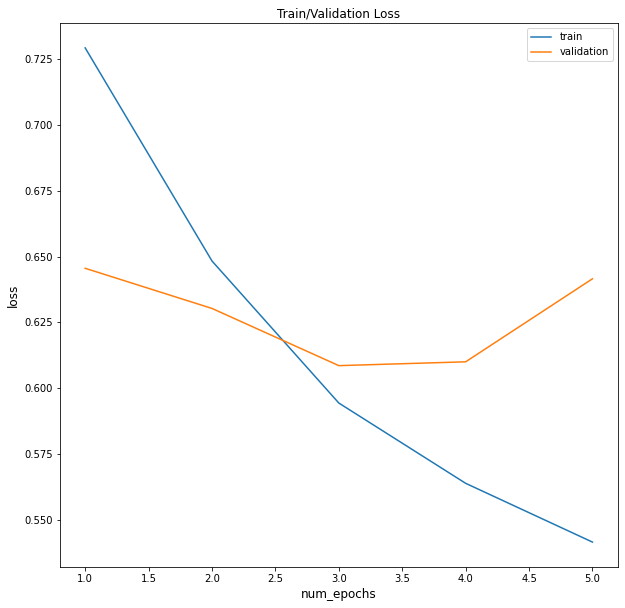

In [42]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

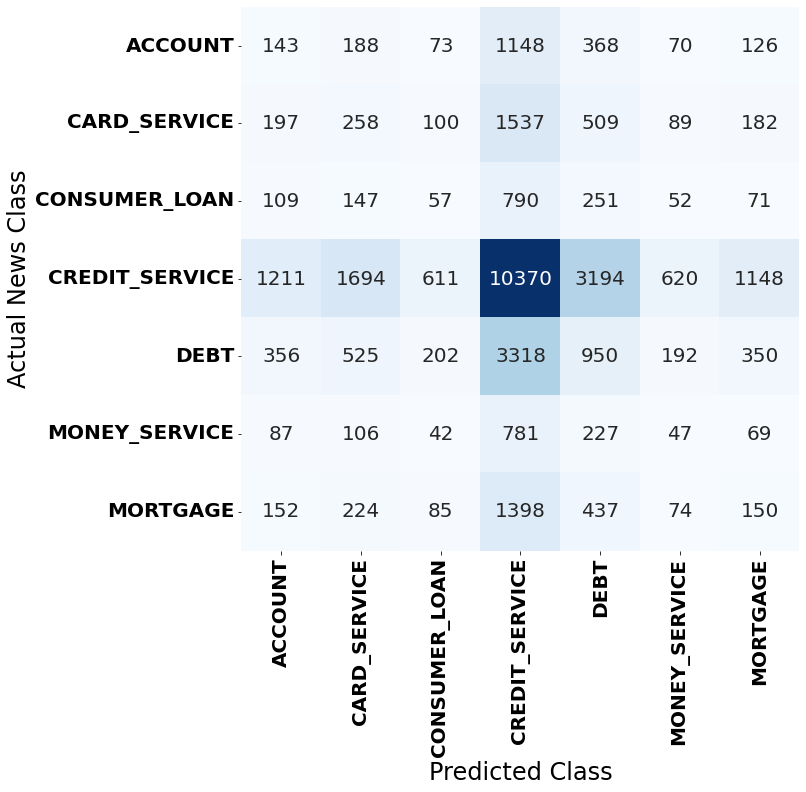

The F1 score of validation set is 0.33762870379803306


In [43]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

df_test = pd.read_csv("complaints_test_notoken.csv")
labels_test = df_test["label"].tolist()
plot_confusion_matrix(labels_test, val_preds, ticklabels)